In [31]:
# Import libraries necessary for this project

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
    
import numpy as np
import pandas as pd
import os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [10]:
os.listdir('/home/jovyan')

['.config',
 '.DS_Store',
 'Dockerfile',
 '.local',
 '.ipython',
 'docker-compose.yml',
 '.keras',
 'data',
 '.cache',
 'notebooks']

In [15]:
df = pd.read_json('/home/jovyan/data/train.jsonl', lines=True)
df = df[["label","text"]]
df.head()
x = df["text"]
y = df["label"]

,label,text
0,0,its their character not their color that matters
1,0,don't be afraid to love again everyone is not ...
2,0,putting bows on your pet
3,0,i love everything and everybody! except for sq...
4,0,"everybody loves chocolate chip cookies, even h..."


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [23]:
tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(x)
xtrain= tokenizer.texts_to_sequences(x_train)
xtest= tokenizer.texts_to_sequences(x_test) 
vocab_size=len(tokenizer.word_index)+1

In [24]:
maxlen=10
xtrain=pad_sequences(xtrain,padding='post', maxlen=maxlen)
xtest=pad_sequences(xtest,padding='post', maxlen=maxlen)

print(x_train[3])
print(xtrain[3])

i'm so patriotic, i piss red, white, and blue my doctor said it may be pancreatic cancer i told him to shut his commie mouth
[ 5 40  6 12 14 22  5 93  4 58]


In [25]:
embedding_dim=50
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=maxlen))
model.add(layers.LSTM(units=50,return_sequences=True))
model.add(layers.LSTM(units=10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", 
     metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 50)            456800    
_________________________________________________________________
lstm (LSTM)                  (None, 10, 50)            20200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 479,537
Trainable params: 479,537
Non-trainable params: 0
________________________________________________

In [27]:
model.fit(xtrain,y_train, epochs=20, batch_size=16, verbose=False)


AttributeError: 'float' object has no attribute 'round'

In [29]:
y_pred = model.predict(xtest).ravel()

In [32]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.5990382317801672


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC curve')

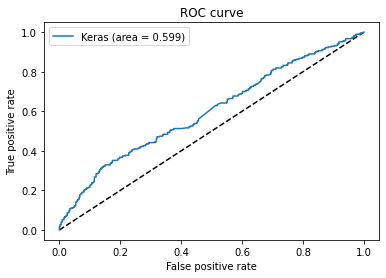

In [34]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [41]:
# validation data
df_dev = pd.read_json('/home/jovyan/data/dev.jsonl', lines=True)
x_dev = df_dev["text"]
y_dev = df_dev["label"]

#tokenizer.fit_on_texts(x_dev)
xdev= tokenizer.texts_to_sequences(x_dev)

maxlen=10
xdev=pad_sequences(xdev,padding='post', maxlen=maxlen)

print(x_dev[3])
print(xdev[3])

it is time.. to send these parasites back to the desert
[14  8 64  4 90  4  1  0  0  0]


In [44]:
y_dev_pred = model.predict(xdev).ravel()
fpr_dev_keras, tpr_dev_keras, thresholds_dev_keras = roc_curve(y_dev, y_dev_pred)
auc_dev_keras = auc(fpr_dev_keras, tpr_dev_keras)
print(y_dev_pred)

0.544072


In [54]:
# final test data
dftest_f = pd.read_json('/home/jovyan/data/test.jsonl', lines=True)
xtest_f = dftest_f["text"]

#tokenizer.fit_on_texts(xtest_f)
xtestf= tokenizer.texts_to_sequences(xtest_f)

maxlen=10
xtestf=pad_sequences(xtestf,padding='post', maxlen=maxlen)

print(xtest_f[3])
print(xtestf[3])

y_test_f_pred = model.predict(xtestf).ravel()

laughs in [majority of u.s crime rate]
[ 9 10  0  0  0  0  0  0  0  0]


In [60]:
df_to_submit = dftest_f[["id"]]
df_to_submit["proba"] = y_test_f_pred
df_to_submit["label"] = df_to_submit['proba'].map(lambda x: 1 if x > 0.5 else 0)
df_to_submit.head()

#print(dftest_f[dftest_f.label == 1])
df_to_submit.to_csv('/home/jovyan/data/csv_to_submit.csv', index = False)


<ipython-input-60-c1ab97234126>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_submit["proba"] = y_test_f_pred


,id,proba,label
0,16395,0.298677,0
1,37405,0.486486,0
2,94180,0.287378,0
3,54321,0.298456,0
4,97015,0.317264,0


In [61]:
tokenizer